In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import time

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib import gridspec

import numpy as np
import scipy as sp
import scipy.sparse as sparse
import numpy.linalg as linalg

from scipy import interpolate
from optimize.snopt7 import SNOPT_solver

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:

# 
# Attempt to solve for the positions of a randomly scattered set of UWB units
#

# Number of units
n = 10
dim = 3
known = 3

#
# Create a random 3D pointset
#
points_truth = np.matrix(np.random.randn(n, dim) * 10)
print "Points: ", points_truth.shape
print points_truth

#
# Calculate the pairwise distances
#
pairwise_dist_truth = sp.spatial.distance.pdist(points_truth)
print "Pairwise distances:", pairwise_dist_truth.shape
print pairwise_dist_truth

Points:  (10, 3)
[[ 13.0115002  -10.40898975   5.22936448]
 [  1.08305644   8.08211362  -8.78380843]
 [ -2.50556588  10.72646457  -8.99853836]
 [ -4.06523298  -1.48724025   9.3637224 ]
 [ -6.05923868  10.43018639  10.27369444]
 [-18.41835584  13.69895673  13.888843  ]
 [  2.74796226   4.22975112  -6.80597461]
 [ 19.47097335   1.57971034   7.08157091]
 [-12.65301334  -3.66489507  -3.13067162]
 [-13.03884074   3.06553937  -6.03391559]]
Pairwise distances: (45,)
[ 26.08788396  29.83152675  19.70546487  28.69511471  40.54646104
  21.55185218  13.74352181  27.82157925  31.41726716   4.46283666
  21.15207538  20.48692854  30.42865641   4.63944338  25.14173817
  18.93752313  15.23666329  22.10836419  19.5993706   28.03363729
   8.63794995  28.72631727  18.56108247  13.35771846  12.1173085
  21.38011766  18.45434153  23.8446516   15.316724    18.39403963
  13.28540311  20.19225794  27.20868069  20.53840829  19.20653574
  31.07980619  40.35859702  24.98812521  23.21475947  21.89853276
  17.6924

In [141]:
#
# Set up optimization problem to solve for positions
#
snopt = SNOPT_solver()
snopt.setOption('Verbose',True)
snopt.setOption('Solution print',False)
snopt.setOption('Print file','uwb1.out')
snopt.setOption('Iteration limit',8000)
snopt.setOption('Print level',3)
snopt.setOption('Major optimality',2e-12)

inf = 1.0e20

x = np.zeros((n, dim))
x = np.matrix(x)
x0 = x.A1

xlow = np.matrix(-inf + np.zeros((n, dim)))
xupp = np.matrix( inf + np.zeros((n, dim)))

#
# I have some known positions
#
for i in range(known):
    xlow[i,:] = points_truth[i,:]
    xupp[i,:] = points_truth[i,:]

low_F = np.array([-inf])
upp_F = np.array([ inf])

def objF(status,x,needF,needG,cu,iu,ru):
    points_estimated = x.reshape((n, dim))
    pairwise_dist_estimated = sp.spatial.distance.pdist(points_estimated)

    return status, [np.sum( (pairwise_dist_estimated - pairwise_dist_truth)**2 )]

a = time.time()
snopt.snopta(name="UWB_1",usrfun=objF,x0=x0,xlow=xlow.A1,xupp=xupp.A1,
             Flow=low_F,Fupp=upp_F,ObjRow=1)
b = time.time()

print "Solved in %.4fs" % (b - a)

print "Value of objective function: %.8f" % snopt.F[0]

 --> Linear component of Jacobian not provided
 --> Nonlinear component of Jacobian not provided
  Could not determine Jacobian structure from user input
  Calling snJac...
 --> Initial xstate not provided; setting to 0
 --> Initial Fstate not provided; setting to 0
----------------------------------------------------------------------------------
 SNOPT python interface   (Feb 2015)
   Problem: UWB_1
   # variables = 30; # constraints = 1 

     Name state(j)      low(j)           x(j)           upp(j)        mul(j)
x:
        0       0    1.301150e+01    0.000000e+00    1.301150e+01    0.000000e+00
        1       0   -1.040899e+01    0.000000e+00   -1.040899e+01    0.000000e+00
        2       0    5.229364e+00    0.000000e+00    5.229364e+00    0.000000e+00
        3       0    1.083056e+00    0.000000e+00    1.083056e+00    0.000000e+00
        4       0    8.082114e+00    0.000000e+00    8.082114e+00    0.000000e+00
        5       0   -8.783808e+00    0.000000e+00   -8.783808e+0

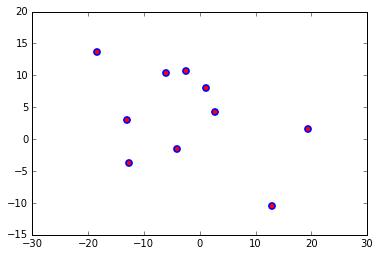

In [142]:
#
# Check the error between solved-for and actual pointset
#
points_estimated = snopt.x.reshape((n, dim))

plt.scatter(points_truth[:,0],points_truth[:,1], c="blue", alpha=1, s=60, linewidth=0)
plt.scatter(points_estimated[:,0],points_estimated[:,1], c="red", alpha=1, linewidth=0)